In [1]:
import json
import os
from sentence_transformers import SentenceTransformer, util
import torch

In [2]:
folder_base = 'datasource'
filename_origin = 'goscv_deduplicate_20221009_train_unpatched.json'
path_file_origin = os.path.join(folder_base, filename_origin)

In [5]:
def load_dataset(path_data):
    with open(path_data ,'r') as file:
        list_content = json.load(file)
    # end
    
    labels_all = set(list(list_content[0]['issues'].keys()))
    labels_all.remove('issueknown')
    labels_all = sorted(list(labels_all))
    label2id = {label:id for id, label in enumerate(labels_all)}
    
    labels_sample = [label for content in list_content for label, flag in content['issues'].items() if flag and label != 'issueknown']
    
    return list_content, labels_sample, label2id
# end

In [6]:
list_content, labels_sample, label2id = load_dataset(path_file_origin)
corpus = [content['processed'] for content in list_content]

embedder = SentenceTransformer('distilbert-base-uncased')
corpus_embeddings = embedder.encode(corpus)

In [10]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

In [11]:
pca = PCA(n_components=100)
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=2000)

corpus_embeddings_pca = pca.fit_transform(corpus_embeddings)
matrix_embeddings_pca = np.array(corpus_embeddings_pca)
# matrix_embeddings_pca = np.array(corpus_embeddings)
matrix_embeddings_pca_tsne = tsne.fit_transform(matrix_embeddings_pca)

In [25]:
list_matrix = matrix_embeddings_pca_tsne.tolist()


list_content_new = []
for content, matrix, label_sample in zip(list_content, list_matrix, labels_sample):
    content_new = {
        'id': content['id'],
        'processed': content['processed'],
        'label': label_sample,
        'point': matrix
    }
    
    list_content_new.append(content_new)
# end


with open('datasource/goscv_deduplicate_20221009_train_unpatched_point.json', 'w+') as file:
    file.write(json.dumps(list_content_new))
# end

/opt/conda/lib/python3.8/site-packages/seaborn/_core.py:881: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  val in data


<AxesSubplot:>

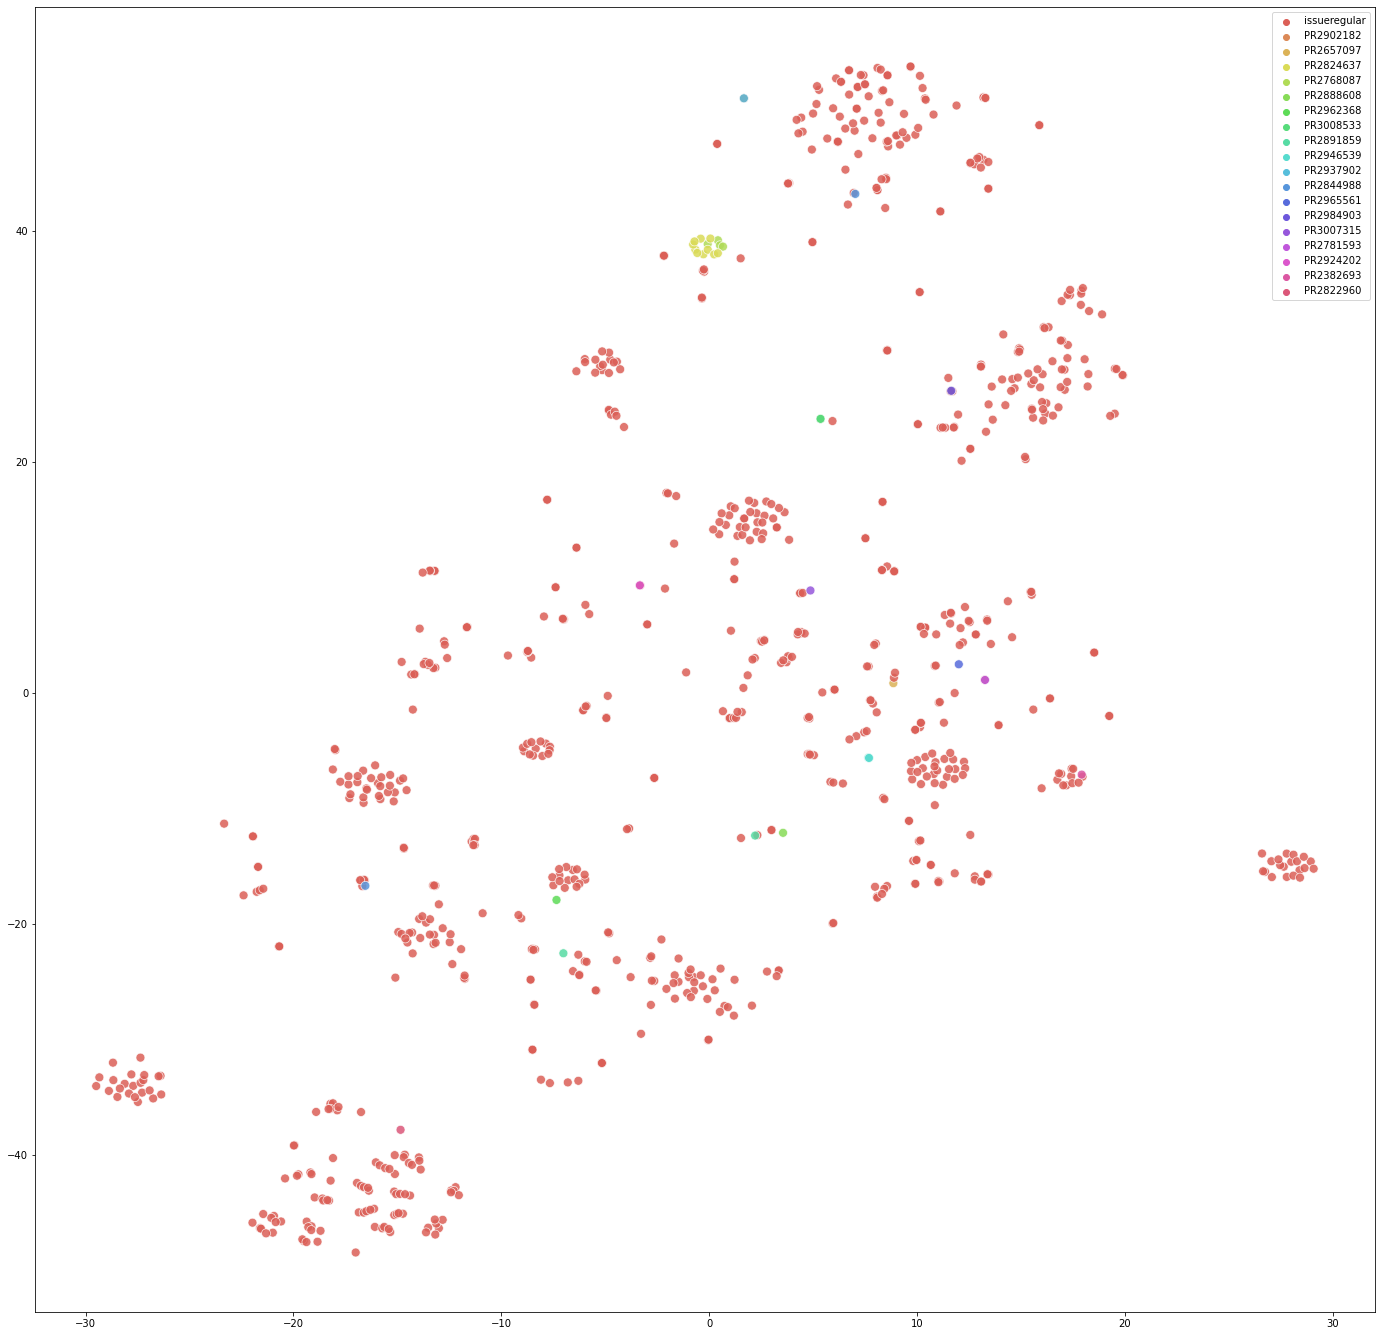

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(24,24))
sns.scatterplot(
    x=matrix_embeddings_pca_tsne[:,0],
    y=matrix_embeddings_pca_tsne[:,1],
    s=[80 for _ in range(len(labels_sample))],
    hue=labels_sample,
    palette=sns.color_palette("hls", len(label2id)),
    data=matrix_embeddings_pca_tsne,
    legend="full",
    alpha=0.85
)

# ax = plt.figure(figsize=(16,10)).gca(projection='3d')
# ax.scatter(
#     xs=matrix_embeddings_pca_tsne[:,0], 
#     ys=matrix_embeddings_pca_tsne[:,1], 
#     zs=matrix_embeddings_pca_tsne[:,2], 
#     c=labels_sample, 
#     cmap='tab10'
# )
# ax.set_xlabel('pca-one')
# ax.set_ylabel('pca-two')
# ax.set_zlabel('pca-three')
# plt.show()